## CEX-DEX Arbitrage Research

Use this Notebook as the starting point for your CEX-DEX arbitrage research.

In [1]:
import os
import asyncio
import nest_asyncio
import aioprocessing
from functools import partial
from dotenv import load_dotenv
import matplotlib.pyplot as plt

load_dotenv(override=True)

HTTP_RPC_URL = os.getenv('HTTP_RPC_URL')
WS_RPC_URL = os.getenv('WS_RPC_URL')

#### Utils

A function for handling websocket connection errors. Wrapping data streaming functions with **reconnecting_websocket_loop** will automatically reconnect everytime a connection error occurs.

In [2]:
from utils import (
    reconnecting_websocket_loop,
    calculate_next_block_base_fee,
)

#### CEX data streams

Currently implemented for Binance websocket stream of depth5 data.

In [3]:
from cex_streams import (
    stream_binance_usdm_orderbook,
    stream_okx_usdm_orderbook,
)

#### DEX data streams

In [4]:
from dex_streams import (
    stream_new_blocks,
    stream_uniswap_v2_events,
)

#### Aggregator

In [5]:
from aggregator import aggregate_cex_orderbooks

#### Event handler

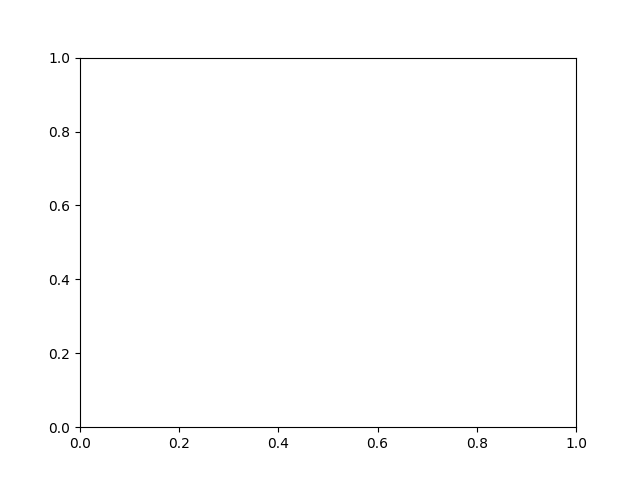

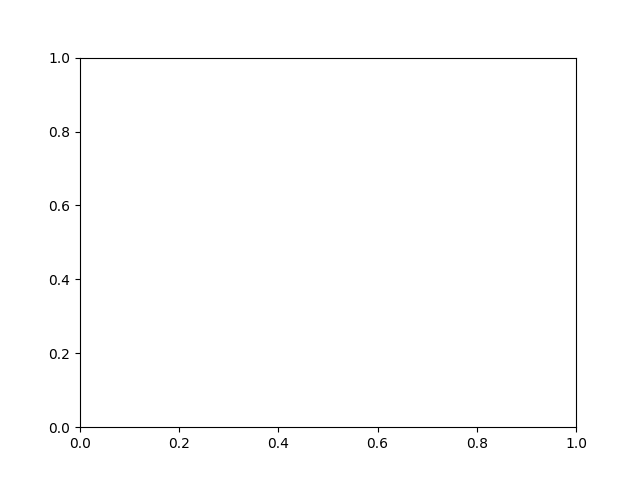

In [6]:
import datetime
from jupyterplot import ProgressPlot

async def cex_event_handler(event_queue: aioprocessing.AioQueue):
    pp = ProgressPlot()
    orderbooks = {}
    
    last_updated = datetime.datetime.now()
    
    while True:
        data = await event_queue.coro_get()
        
        symbol = data['symbol']
        
        if data['source'] == 'cex':
            if symbol not in orderbooks:
                orderbooks[symbol] = {}
                
            orderbooks[symbol][data['exchange']] = data
            multi_orderbook = aggregate_cex_orderbooks(orderbooks[symbol])
            
            now = datetime.datetime.now()
            if (now - last_updated).total_seconds() > 1:
                best_bid = multi_orderbook['bids'][0][0]
                best_ask = multi_orderbook['asks'][0][0]
                bid_ask_spread = (best_bid / best_ask - 1) * 100
                pp.update(bid_ask_spread)
                
                last_updated = now
                print(f'[{now}] Spread: {round(bid_ask_spread, 3)}%')

In [8]:
async def event_handler(event_queue: aioprocessing.AioQueue):
    while True:
        data = await event_queue.coro_get()
        print(data)

#### Run streams

In [7]:
nest_asyncio.apply()

# define an event_queue to publish realtime data
event_queue = aioprocessing.AioQueue()

symbols = ['ETH/USDT']

binance_stream = reconnecting_websocket_loop(
    partial(stream_binance_usdm_orderbook, symbols, event_queue),
    tag='binance_stream'
)

okx_stream = reconnecting_websocket_loop(
    partial(stream_okx_usdm_orderbook, symbols, event_queue),
    tag='okx_stream'
)

event_handler_loop = cex_event_handler(event_queue)

loop = asyncio.get_event_loop()
loop.run_until_complete(asyncio.wait([
    binance_stream,
    okx_stream,
    event_handler_loop,
]))

[2023-08-08 14:19:45.602110] Spread: 0.033%
[2023-08-08 14:19:46.655924] Spread: 0.033%
[2023-08-08 14:19:47.694716] Spread: 0.033%
[2023-08-08 14:19:48.764062] Spread: 0.033%
[2023-08-08 14:19:49.821529] Spread: 0.033%
[2023-08-08 14:19:50.822653] Spread: 0.033%
[2023-08-08 14:19:51.853992] Spread: 0.033%
[2023-08-08 14:19:52.953533] Spread: 0.033%
[2023-08-08 14:19:53.995058] Spread: 0.033%
[2023-08-08 14:19:55.074052] Spread: 0.033%


[2023-08-08 14:19:56.077805] Spread: 0.033%
